==========================================
Bike Sharing Dataset
==========================================

Hadi Fanaee-T

https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#

Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto
INESC Porto, Campus da FEUP
Rua Dr. Roberto Frias, 378
4200 - 465 Porto, Portugal


=========================================
Background 
=========================================

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.

=========================================
Data Set
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

=========================================
Associated tasks
=========================================

	- Regression: 
		Predication of bike rental count hourly or daily based on the environmental and seasonal settings.
	
	- Event and Anomaly Detection:  
		Count of rented bikes are also correlated to some events in the town which easily are traceable via search engines.
		For instance, query like "2012-10-30 washington d.c." in Google returns related results to Hurricane Sandy. Some of the important events are 
		identified in [1]. Therefore the data can be used for validation of anomaly or event detection algorithms as well.


=========================================
Files
=========================================

	- Readme.txt
	- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
	- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

	
=========================================
Dataset characteristics
=========================================	
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

### Goal: To build a prediction model for the hourly utilization “cnt”  

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['image.cmap'] = 'viridis'

from scipy import stats
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,LassoCV, Ridge
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgb


# Metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
 


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [2]:
df_hour = pd.read_csv('./hour.csv')
df_hour.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [3]:
# We have around 17300 of samples

df_hour.shape

(17379, 17)

In [4]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [5]:
# No missing values. Therefore we dont need any kind of data imputation.

df_hour.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
# The number of unique 'instant' values is equal to the number of samples, therefore, I think that this 
# feature can be neglected for further analysis

len(df_hour.instant.unique())

17379

### EDA

For the sake of simplicity lets ommit time feature.

In [7]:
# Let us drop the 'instant' column, dont really useful for regression purposes

df = df_hour.drop(['instant','dteday'], axis=1)
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


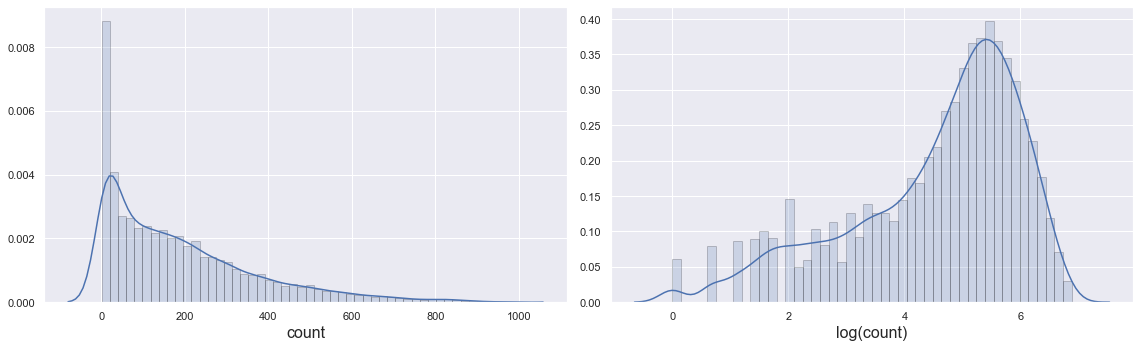

In [8]:
# Lets check underlying distribution of 'cnt' variable. Looks more like Poisson distribution.
# For some ML algorithms like OLS and it is derivatives (Ridge, Lasso) we would like to have
# normally distributed target vector (counts). Hence we would need to log transform it.

# Distribution of cnt
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(df['cnt'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(df['cnt']), ax=ax[1], hist_kws=hist_kws)
ax[0].set_xlabel('count', fontsize=16)
ax[1].set_xlabel('log(count)', fontsize=16)
plt.tight_layout()
plt.show()

In the above plot, we see that the variable `cnt` is prominently skewed right which reminds of POisson distribution. The log tranform looks normally distributed. Lets conduct `Shapiro-Wilk` test in order to prove it.

In [9]:
stat, p = stats.shapiro(np.log(df['cnt']))
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05

if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)


The target vector seems to be not normal, however let us conduct one more test and build Q-Q plot.

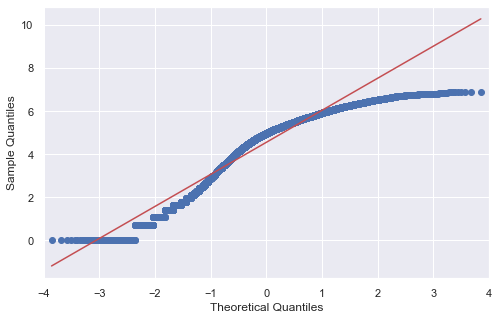

In [10]:
import statsmodels.api as sm
import pylab

sm.qqplot(np.log(df['cnt']), line='s')

pylab.show()

So our our first assumption is proved that even log-transform of the target vector is not normally distributed, therefore we would expect the linear regressions methods to fail.

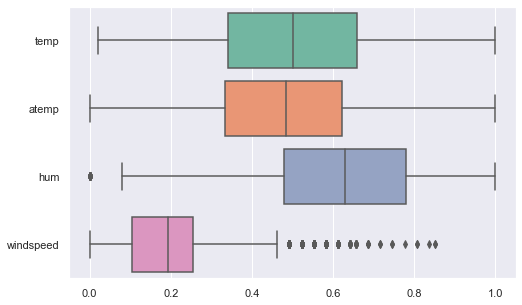

In [11]:
# Outliers. Let us check numerical features for outliers, we will do that with box plots

features = ['temp','atemp','hum','windspeed']

ax = sns.boxplot(data=df[features], orient="h", palette="Set2")

The one can see quite some outliers in `windspeed` feature and a few in `humidity`. We sould check maximum values and get rid of outliers.

In [12]:
df.sort_values(by='windspeed', ascending=False).head(20)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
4315,3,0,7,17,0,0,0,3,0.80,0.7424,0.49,0.8507,181,177,358
4316,3,0,7,18,0,0,0,3,0.80,0.7424,0.49,0.8507,74,107,181
5635,3,0,8,17,0,6,0,3,0.64,0.5758,0.89,0.8358,2,14,16
9956,1,1,2,21,0,5,1,1,0.42,0.4242,0.35,0.8060,1,151,152
1259,1,0,2,15,0,5,1,1,0.46,0.4545,0.41,0.8060,5,50,55
1017,1,0,2,1,0,2,1,1,0.30,0.2424,0.42,0.7761,0,5,5
1261,1,0,2,17,0,5,1,1,0.32,0.2727,0.49,0.7463,8,181,189
1125,1,0,2,15,0,6,0,1,0.44,0.4394,0.16,0.7463,84,87,171
9653,1,1,2,4,0,0,0,2,0.10,0.0455,0.46,0.7164,0,1,1
11024,2,1,4,12,0,1,1,1,0.54,0.5152,0.28,0.7164,94,186,280


The top-2 values belong to the same day, 5 and 6 am. Maybe there was some extraordinary storm or smth, don't really think that we should clear this column. 

In [13]:
df.sort_values(by='hum', ascending=True).head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1565,1,0,3,16,0,4,1,3,0.42,0.4242,0.0,0.2537,1,20,21
1570,1,0,3,21,0,4,1,3,0.36,0.3485,0.0,0.2239,1,27,28
1568,1,0,3,19,0,4,1,3,0.44,0.4394,0.0,0.5821,5,51,56
1567,1,0,3,18,0,4,1,3,0.44,0.4394,0.0,0.3582,2,80,82
1566,1,0,3,17,0,4,1,2,0.44,0.4394,0.0,0.3881,2,109,111
1564,1,0,3,15,0,4,1,3,0.44,0.4394,0.0,0.2239,3,11,14
1563,1,0,3,14,0,4,1,3,0.44,0.4394,0.0,0.2985,0,12,12
1562,1,0,3,13,0,4,1,3,0.42,0.4242,0.0,0.2239,1,11,12
1561,1,0,3,12,0,4,1,3,0.42,0.4242,0.0,0.2239,4,30,34
1571,1,0,3,22,0,4,1,2,0.34,0.3333,0.0,0.1343,4,30,34


Having `hum` equal to 0 is quite an outlier because the lowest humidity is found in Antarctica where it is so cold all the moisture has frozen out of the air as frost. Therefore we need to count how many such samples do we have. 

In [14]:
df[df['hum'] == 0.0].count()

season        22
yr            22
mnth          22
hr            22
holiday       22
weekday       22
workingday    22
weathersit    22
temp          22
atemp         22
hum           22
windspeed     22
casual        22
registered    22
cnt           22
dtype: int64

So we have only 22 samples out of 18000. We could simply delete these, because some ML models are very sensitive to outliers (i.e SVM) on the other hand if we would have such samples in a test set, deleting such outlier means to lose generalization capacity.

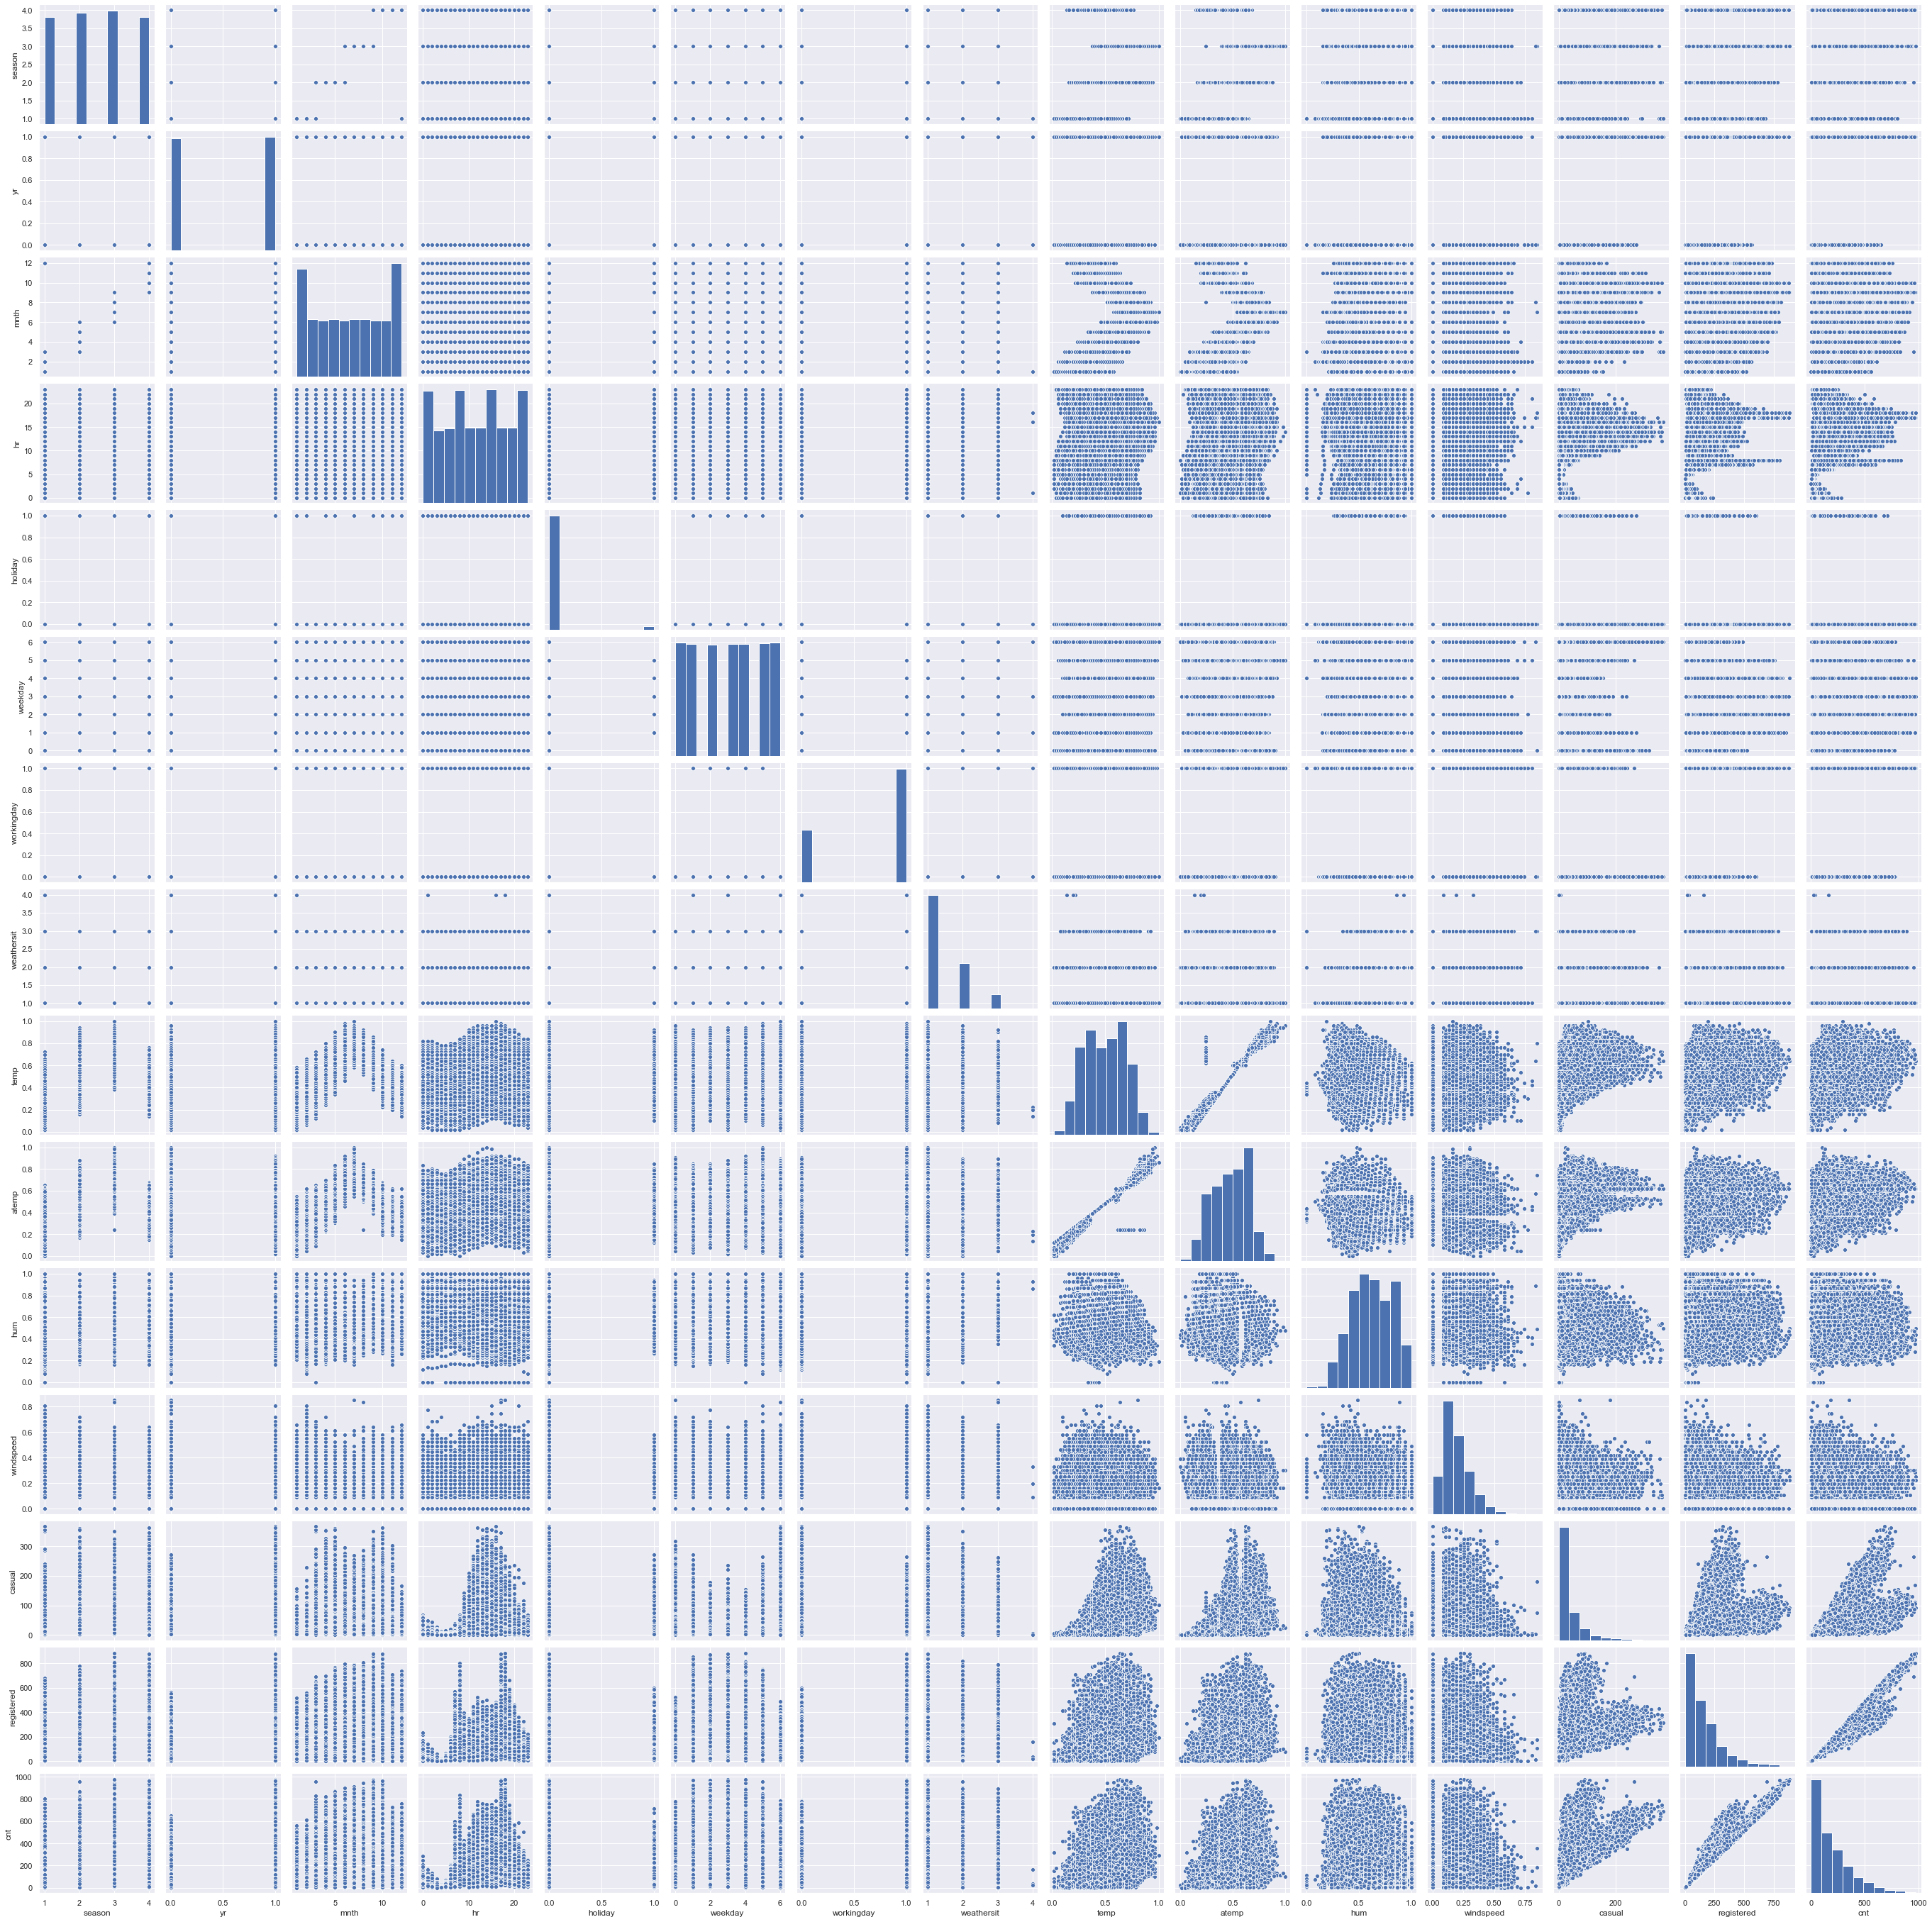

In [15]:
# In some cases, we may want to plot a scatterplot matrix such as the one shown below. 
# Its diagonal contains the distributions of the corresponding variables, and 
# the scatter plots for each pair of variables fill the rest of the matrix.


%config InlineBackend.figure_format = 'png'
sns.pairplot(df);

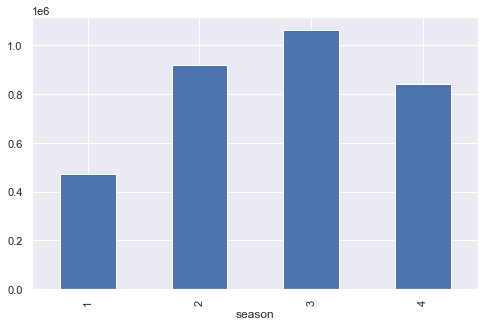

In [16]:
df.groupby(['season'])['cnt'].sum().plot(kind='bar')

In [17]:
df.groupby(['season'])['cnt'].sum()

season
1     471348
2     918589
3    1061129
4     841613
Name: cnt, dtype: int64

It is clear that the $summer$ months have the highest count, although $autumn$ monhts are not that far away 

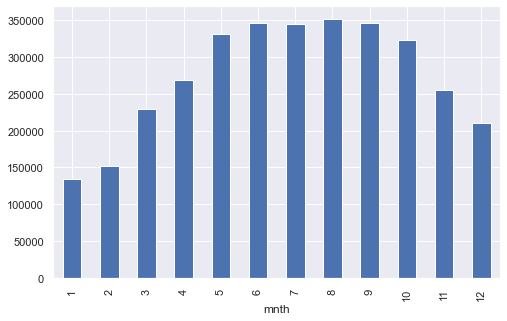

In [18]:
# Distribution over months is oppoite to what we ve observed above

df.groupby(['mnth'])['cnt'].sum().plot(kind='bar')

If we plot the `cnt` values w.r.t months, we see that three summer months have bigger values (expected), than any other months.

In [19]:
# Lets count manually count of rents in three 'summer' monts

df[df_hour['mnth'].apply(lambda x: (x == 6)|(x == 7)|(x == 8))]['cnt'].sum()

1042484

In [20]:
# Lets count manually anount of rents in three 'autumn' monts

df[df['mnth'].apply(lambda x: (x == 9)|(x == 10)|(x == 11))]['cnt'].sum()

923174

Our assumption is correct

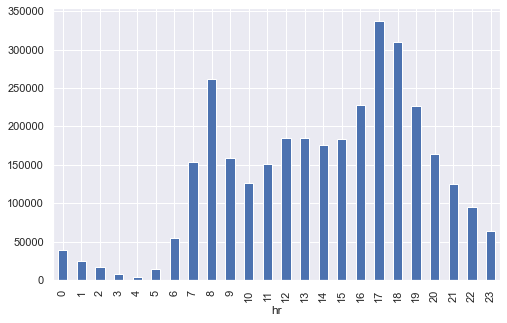

In [21]:
# Now let see the distribution of rental bikes w r t hours

df.groupby(['hr'])['cnt'].sum().plot(kind='bar')

The pattern is pretty clear, very low values at night, than bikes rental starts to grow more or less linearly. Two spikes which can be observed at 8 am and 5 pm, i believe correspond to the time when people go to/from work.

Next is to check how cnt feature relates to weather.
Weathersit : 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

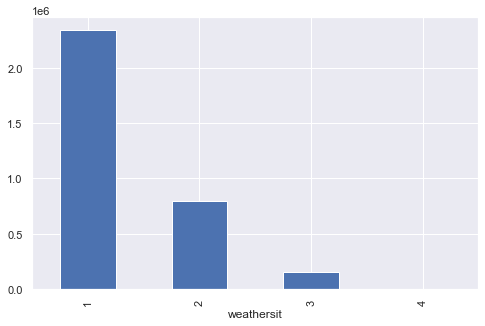

In [22]:
df.groupby(['weathersit'])['cnt'].sum().plot(kind='bar')

As we can see the majority of the people drive bike only when the weather conditions are good. 

In [23]:
# What about holydays and working days

df.groupby(['holiday'])['cnt'].sum()

holiday
0    3214244
1      78435
Name: cnt, dtype: int64

In [24]:
df.groupby(['workingday'])['cnt'].sum()

workingday
0    1000269
1    2292410
Name: cnt, dtype: int64

As we would expect people tend to do rent bikes in working days, to go to/from work. This conncusion is supported by hour observation.


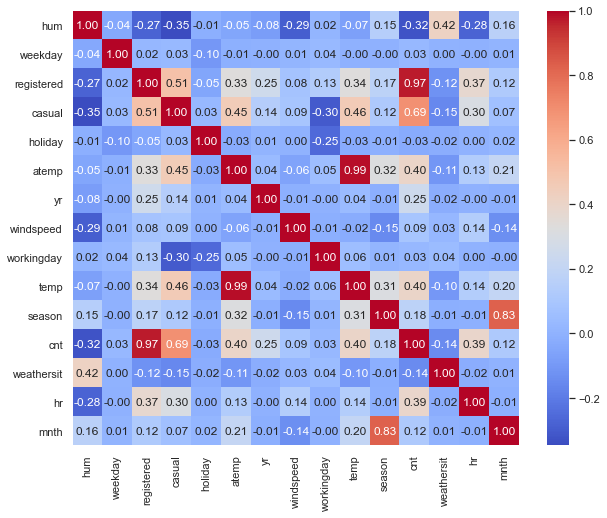

In [25]:
#Lets plot simple correlation matrix

plt.figure(figsize=(10, 8))
numerical = list(set(df.columns))
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix,annot=True,fmt = ".2f", cmap = "coolwarm")

The one can see that `cnt` feature is highly correlated with `hrs`, `casual`, `temperature` and all other features which represent weather conditions. What is surprising is a weak correlation with `weekday` and `working day`. There is an almost linear relation between `cnt` and `registered`, since `cnt` is consist of `registered` and `casual`, we can also drop these features as they will not help us model demand from single user behavior and work only with the `total count`. Basically, if we do not drop them, we will introduce leakage our linear models like `Ridge` and `Lasso` outperform all other and show minimum *MAE* and *RMSE*.

### Modeling

We going to train some simple ML models. The main question is to choose cost function that would do the best job in describing our model. Since we have outliers in the data and If I wanted to downplay their significance, I would use the MAE since the outlier residuals won't contribute as much to the total error as MSE. The one could argue about R2, but personally, I find it to be the not the ideal metric for assessing regression results, as we are mostly interested in either forecasting or predicting a value, so the error is more useful.

In [26]:
df.head(15)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


We need to one-hot encode a set of values in order to be able to use them.

In [27]:
features_to_encode = ['season','yr','mnth','hr','holiday','weekday','workingday','weathersit']

def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [28]:
# Define and log-transform the target labels and drop 'casual' and 'registered' columns

features_to_drop = ['casual', 'registered']
df = df.drop(features_to_drop, axis=1)
Y = np.log(df.iloc[:,-1]).values

In [29]:
# One - hot encode 'categorical' features and drop the original one.

df_train = one_hot(df, features_to_encode)
df_train = df_train.drop(features_to_encode, axis=1)
df_train.head()

,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,yr_0,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.2879,0.81,0.0,16,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
1,0.22,0.2727,0.80,0.0,40,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,0.22,0.2727,0.80,0.0,32,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,0.24,0.2879,0.75,0.0,13,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
4,0.24,0.2879,0.75,0.0,1,1,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0


In [30]:
df_train.shape

(17379, 62)

In [31]:
# Target labels for the training set and the traiing set itself

X = df_train.drop(['cnt'], axis=1)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3, 
                                                          random_state=17)

In [32]:
# import some helper 

n_folds = 5
random_state = 17

def rmse_mae(model):
    
    kf = KFold(n_folds, shuffle=True, random_state=random_state).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    mae = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf))
    
    return rmse,mae

def beatiful_coef(coefs, feature_names=X.columns):
    return pd.DataFrame(coefs, index=feature_names,
                       columns=['coef']).sort_values('coef',
                                                  ascending=False)


def rmse(y_pred,y_true):
    result = np.sqrt(mean_squared_error(y_true,y_pred))
    
    return result

def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))

In [33]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,
random_state=random_state)    

# Cross validate model with Kfold stratified cross val

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=random_state))
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=random_state))
forest = RandomForestRegressor(random_state=random_state)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=0.05, max_depth=3, 
                         min_child_weight=1.7817, n_estimators=2200,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)

In [34]:
%%time

score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(ridge)
score_forest_rmse,score_forest_mae = rmse_mae(forest)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
                                        
print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("Random Forest score RMSE: {:.4f} ({:.4f})\n".format(score_forest_rmse.mean(), score_forest_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score MAE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("Random Forest score MAE: {:.4f} ({:.4f})\n".format(score_forest_mae.mean(), score_forest_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))


[18:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

In [35]:
regressions(lasso)

MAE : 0.470793
RMSE : 0.629650
R2 : 0.816002


In [36]:
regressions(ridge)

MAE : 0.471127
RMSE : 0.630217
R2 : 0.815671


In [37]:
regressions(forest)

MAE : 0.235216
RMSE : 0.353154
R2 : 0.942118


In [38]:
regressions(model_xgb)

[18:52:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


MAE : 0.221371
RMSE : 0.326716
R2 : 0.950460


Results are pretty interesting. Gradient Boosting and RF outperformed classical linear regression models as Ridge and Lasso (they differ only in their regularization scheme: $l2$ vs $l1$). Let us explore a bit more models.

In [39]:
# Modeling step Test different algorithms 

kfold = 5

# Cross validate model with Kfold stratified cross val
regressors = []

regressors.append(DecisionTreeRegressor(random_state=random_state))
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state)))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(ExtraTreesRegressor(random_state=random_state))
regressors.append(GradientBoostingRegressor(random_state=random_state))
regressors.append(BaggingRegressor(random_state=random_state))
regressors.append(make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=random_state)))
regressors.append(make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=random_state)))
regressors.append(xgb.XGBRegressor(random_state=random_state))
regressors.append(lgb.LGBMRegressor(random_state = random_state))

In [40]:
%%time

cv_results = []
for regressor in regressors :
    print(regressor)
    cv_results.append(-cross_val_score(regressor, X_train, y = y_train, scoring = "neg_mean_absolute_error", cv = kfold,n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

DecisionTreeRegressor(random_state=17)
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=17))
RandomForestRegressor(random_state=17)
ExtraTreesRegressor(random_state=17)
GradientBoostingRegressor(random_state=17)
BaggingRegressor(random_state=17)
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lasso', Lasso(alpha=0.0005, random_state=17))])
Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridge', Ridge(alpha=0.0005, random_state=17))])
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=17, reg_alpha=None, reg_lambda=None,
       

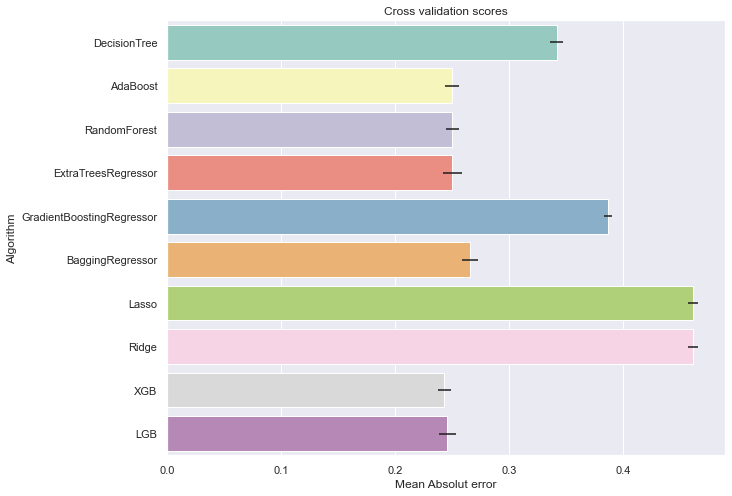

In [41]:
import seaborn as sns

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTreesRegressor","GradientBoostingRegressor","BaggingRegressor","Lasso","Ridge",'XGB','LGB']})
plt.figure(figsize=(10, 8))
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Absolut error")
g = g.set_title("Cross validation scores")

**Conclusion**: 


- In this work, we briefly faced a task of Bike sharing prediction. Due to the continuous nature of the target variables, the task is labeled as regression one. In the first part **EDA** dataset was briefly analyzed in order to have a glimpse for simple patterns that can be observed from data. Based on that different strategies to deal with outliers and feature engineering can be conducted. In our case, we did not really have any outliers, but there is some possibility for **Feature Engineering**, for instance, we could create several features based on ´hour´, like: ´morning´,´day´,´evening´ etc. 

 - Then in **Modeling** part, we have tested different regression algorithms (out-of-the-box), which resulted in the best score for Light Gradient Boosting Machine. I believe that the reason why it is overcome other boosting techniques is that it produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. 
 
 - Surely there are plenty of things that could be done, for example as I said earlier - Feature Engineering can be conducted, also the one can tune hyper-parameters of the learning algorithm and of course the nature of **Time-Series** data has to be leveraged. A few interesting kernels in this regards are:
 
  - https://github.com/Lodur03/Bike-Sharing-Prediction-with-NeuralNet/blob/master/Your_first_neural_network.ipynb
  - https://www.kaggle.com/abdul002/bike-sharing-rental-prediction